# Imports

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate

# Configs

In [50]:
BASE_PATH = "data/"

LABELED_PATH = BASE_PATH + "labels.parquet"
XGB_MODEL_PATH = BASE_PATH + "results/xgb_predictions.parquet"
OLD_XGB_MODEL_PATH = BASE_PATH + "results/xgb_predictions_old.parquet"
RIDGE_MODEL_PATH = BASE_PATH + "results/ridge_test_predictions.parquet"
RF_MODEL_PATH = BASE_PATH + "results/rf_predictions.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'

MODEL_LIST = ['BASELINE_LAST_WEEK', 'RIDGE_MODEL', 'XGB_MODEL', 'RF_MODEL', 'OLD_XGB_MODEL']
CATEGORIES = ['high_demand_locations', 'low_demand_locations', 'all_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['Location', 'Date', 'Day_of_week']



TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'



HIGH_DEMAND_NUMS = 50
NUM_LOC = 262

SORT_METHODE = 'mean'

warnings.filterwarnings('ignore')

In [51]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS + ['MEAN']} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [52]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [53]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df.head()

,Location,Date,Demand
0,1,2023-04-01,13.0
1,1,2023-04-02,17.0
2,1,2023-04-03,9.0
3,1,2023-04-04,12.0
4,1,2023-04-05,18.0


## Load Predicted Data

In [54]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of RIDGE_MODEL (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,16.058503
1,1,2023-04-02,19.940854
2,1,2023-04-03,10.172899
3,1,2023-04-04,10.371798
4,1,2023-04-05,9.977403


shape of XGB_MODEL (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,17.433596
1,1,2023-04-02,15.451467
2,1,2023-04-03,12.600250
3,1,2023-04-04,9.332970
4,1,2023-04-05,11.754244


shape of RF_MODEL (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,12.382074
1,1,2023-04-02,13.698427
2,1,2023-04-03,10.275906
3,1,2023-04-04,10.065382
4,1,2023-04-05,11.226349


shape of OLD_XGB_MODEL (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,16.912674
1,1,2023-04-02,18.158730
2,1,2023-04-03,11.263210
3,1,2023-04-04,11.029713
4,1,2023-04-05,11.032634


### BaseLine Models

In [55]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['Location', 'Date']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [56]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(7860, 3)


,Location,Date,Predicted_demand
7,1,2023-04-01,15.0
8,1,2023-04-02,14.0
9,1,2023-04-03,3.0
10,1,2023-04-04,14.0
11,1,2023-04-05,7.0


### Join Predictions and Actual

In [57]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['Location', 'Date'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [58]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,15.0,5
1,1,2023-04-02,17.0,14.0,6
2,1,2023-04-03,9.0,3.0,0
3,1,2023-04-04,12.0,14.0,1
4,1,2023-04-05,18.0,7.0,2


shape of predictions_dict[RIDGE_MODEL]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,16.058503,5
1,1,2023-04-02,17.0,19.940854,6
2,1,2023-04-03,9.0,10.172899,0
3,1,2023-04-04,12.0,10.371798,1
4,1,2023-04-05,18.0,9.977403,2


shape of predictions_dict[XGB_MODEL]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,17.433596,5
1,1,2023-04-02,17.0,15.451467,6
2,1,2023-04-03,9.0,12.600250,0
3,1,2023-04-04,12.0,9.332970,1
4,1,2023-04-05,18.0,11.754244,2


shape of predictions_dict[RF_MODEL]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,12.382074,5
1,1,2023-04-02,17.0,13.698427,6
2,1,2023-04-03,9.0,10.275906,0
3,1,2023-04-04,12.0,10.065382,1
4,1,2023-04-05,18.0,11.226349,2


shape of predictions_dict[OLD_XGB_MODEL]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,16.912674,5
1,1,2023-04-02,17.0,18.158730,6
2,1,2023-04-03,9.0,11.263210,0
3,1,2023-04-04,12.0,11.029713,1
4,1,2023-04-05,18.0,11.032634,2


### Sort Locations by Demand

In [59]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        sorted_index = predictions_df.groupby(['Location'])['Demand'].aggregate([SORT_METHODE]).sort_values(SORT_METHODE, ascending=False)
        sorted_index = sorted_index.reset_index()
        sorted_locations_dict['high_demand_locations'] = sorted_index[:HIGH_DEMAND_NUMS]
        sorted_locations_dict['low_demand_locations'] = sorted_index[HIGH_DEMAND_NUMS:]
        sorted_locations_dict['all_locations'] = sorted_index

In [60]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_locations]: (50, 2)


,Location,mean
0,132,5778.500000
1,237,5125.966667
2,161,4969.933333
3,236,4610.533333
4,142,3781.600000


shape of sorted_locations_dict[low_demand_locations]: (212, 2)


,Location,mean
50,88,291.266667
51,41,266.600000
52,74,234.766667
53,209,185.966667
54,45,148.866667


shape of sorted_locations_dict[all_locations]: (262, 2)


,Location,mean
0,132,5778.500000
1,237,5125.966667
2,161,4969.933333
3,236,4610.533333
4,142,3781.600000


# Mean error Calculation

### Error Columns

In [61]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [62]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,15.0,5,2.0,4.0,15.384615
1,1,2023-04-02,17.0,14.0,6,3.0,9.0,17.647059
2,1,2023-04-03,9.0,3.0,0,6.0,36.0,66.666667
3,1,2023-04-04,12.0,14.0,1,2.0,4.0,16.666667
4,1,2023-04-05,18.0,7.0,2,11.0,121.0,61.111111


shape of predictions_dict[RIDGE_MODEL]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,16.058503,5,3.058503,9.354442,23.526948
1,1,2023-04-02,17.0,19.940854,6,2.940854,8.648623,17.299142
2,1,2023-04-03,9.0,10.172899,0,1.172899,1.375693,13.032214
3,1,2023-04-04,12.0,10.371798,1,1.628202,2.651043,13.568353
4,1,2023-04-05,18.0,9.977403,2,8.022597,64.362061,44.569983


shape of predictions_dict[XGB_MODEL]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,17.433596,5,4.433596,19.656770,34.104582
1,1,2023-04-02,17.0,15.451467,6,1.548533,2.397956,9.109020
2,1,2023-04-03,9.0,12.600250,0,3.600250,12.961802,40.002780
3,1,2023-04-04,12.0,9.332970,1,2.667030,7.113051,22.225253
4,1,2023-04-05,18.0,11.754244,2,6.245756,39.009470,34.698645


shape of predictions_dict[RF_MODEL]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,12.382074,5,0.617926,0.381833,4.753277
1,1,2023-04-02,17.0,13.698427,6,3.301573,10.900385,19.421018
2,1,2023-04-03,9.0,10.275906,0,1.275906,1.627937,14.176738
3,1,2023-04-04,12.0,10.065382,1,1.934618,3.742748,16.121819
4,1,2023-04-05,18.0,11.226349,2,6.773651,45.882342,37.631392


shape of predictions_dict[OLD_XGB_MODEL]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,16.912674,5,3.912674,15.309017,30.097492
1,1,2023-04-02,17.0,18.158730,6,1.158730,1.342654,6.816056
2,1,2023-04-03,9.0,11.263210,0,2.263210,5.122121,25.146781
3,1,2023-04-04,12.0,11.029713,1,0.970287,0.941457,8.085728
4,1,2023-04-05,18.0,11.032634,2,6.967366,48.544192,38.707590


### Aggregate Error Columns

In [63]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['Location']], on=['Location'])
                
                for per in BASED_ON:
                    categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                    categorized_mean_df = (
                        categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                              mae=('error','mean'),
                                                              mse=('squared_error','mean'),
                                                              demand_mean=('Demand','mean'))
                                                              ) 
                    categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                    categorized_mean_df.drop(columns='mse', inplace=True)
                    categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                    
                    if per == 'Location':
                        loc_demand_index = sorted_locations.groupby(['Location'])[SORT_METHODE].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
           
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()
                        


In [64]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,8.828638,489.700000,5778.500000,658.539774
1,237,8.273841,433.300000,5125.966667,556.367654
2,161,5.730011,276.266667,4969.933333,329.958179
3,236,10.942045,514.666667,4610.533333,632.673902
4,142,9.096718,345.266667,3781.600000,428.297794


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][low_demand_locations]: (212, 5)


,Location,mape,mae,demand_mean,rmse
0,88,12.025720,35.500000,291.266667,43.793835
1,41,14.977841,38.766667,266.600000,46.209306
2,74,14.014968,33.566667,234.766667,39.568085
3,209,15.217230,30.800000,185.966667,43.909756
4,45,9.732519,14.266667,148.866667,18.688677


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,8.828638,489.700000,5778.500000,658.539774
1,237,8.273841,433.300000,5125.966667,556.367654
2,161,5.730011,276.266667,4969.933333,329.958179
3,236,10.942045,514.666667,4610.533333,632.673902
4,142,9.096718,345.266667,3781.600000,428.297794


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,5.644475,104.10,2252.92,137.352758
1,2023-04-02,7.009985,139.90,1919.74,193.171892
2,2023-04-03,7.167933,132.18,1869.88,194.083333
3,2023-04-04,7.855529,145.20,2097.82,228.671380
4,2023-04-05,9.543244,185.66,2239.04,303.579215


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,54.189886,4.773585,20.542453,12.538996
1,2023-04-02,58.245852,4.023585,18.344340,8.490561
2,2023-04-03,51.288336,3.910377,16.136792,8.290993
3,2023-04-04,57.693931,4.174528,17.443396,7.384009
4,2023-04-05,49.266198,4.070755,17.443396,9.111210


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,44.925494,23.729008,446.568702,61.053756
1,2023-04-02,48.468014,29.954198,381.206107,84.732448
2,2023-04-03,42.868411,28.389313,369.904580,85.113081
3,2023-04-04,48.182786,31.087786,414.461832,100.116135
4,2023-04-05,41.685482,38.725191,441.412214,132.872205


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,8.789871,156.825,1856.735,236.977372
1,1,7.982002,158.045,2137.385,237.413174
2,2,8.477095,161.260,2261.655,253.601893
3,3,9.140040,196.575,2322.565,276.949517
4,4,10.458526,230.215,2267.435,334.818257


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,55.102985,3.882075,15.488208,8.008398
1,1,62.950029,4.280660,16.399764,8.302080
2,2,56.246793,4.254717,17.015330,9.277814
3,3,56.727255,4.833726,18.667453,10.210809
4,4,55.960408,4.804245,19.614387,11.297437


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,46.264605,33.069656,366.871183,103.774386
1,1,52.459947,33.625000,421.167939,103.982947
2,2,47.130439,34.217557,445.381679,111.100403
3,3,47.645725,41.425573,458.342557,121.334108
4,4,47.276843,47.821565,448.587786,146.618647


shape of predictions_mean_dict[RIDGE_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,5.590186,310.482416,5778.500000,424.863227
1,237,6.044361,315.563024,5125.966667,388.867007
2,161,4.846549,209.179474,4969.933333,249.141626
3,236,7.641231,362.496824,4610.533333,451.179558
4,142,6.606375,256.380068,3781.600000,315.643798


shape of predictions_mean_dict[RIDGE_MODEL][Location][low_demand_locations]: (212, 5)


,Location,mape,mae,demand_mean,rmse
0,88,11.973354,33.174950,291.266667,45.340208
1,41,11.302459,29.073700,266.600000,32.790277
2,74,11.507670,27.670296,234.766667,33.320235
3,209,13.814806,26.045354,185.966667,32.861154
4,45,9.655621,13.832316,148.866667,16.593409


shape of predictions_mean_dict[RIDGE_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,5.590186,310.482416,5778.500000,424.863227
1,237,6.044361,315.563024,5125.966667,388.867007
2,161,4.846549,209.179474,4969.933333,249.141626
3,236,7.641231,362.496824,4610.533333,451.179558
4,142,6.606375,256.380068,3781.600000,315.643798


shape of predictions_mean_dict[RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,3.894079,72.215498,2252.92,104.483310
1,2023-04-02,4.360447,78.293269,1919.74,106.912039
2,2023-04-03,6.768104,129.960788,1869.88,201.001730
3,2023-04-04,6.301481,116.605406,2097.82,170.911348
4,2023-04-05,8.656670,167.968908,2239.04,251.255781


shape of predictions_mean_dict[RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,70.452121,4.606296,20.542453,13.199207
1,2023-04-02,63.984487,3.102698,18.344340,5.715422
2,2023-04-03,61.406043,3.433168,16.136792,6.467302
3,2023-04-04,58.708498,3.509953,17.443396,5.910089
4,2023-04-05,53.584780,3.743060,17.443396,8.010714


shape of predictions_mean_dict[RIDGE_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,57.750204,17.508815,446.568702,47.162726
1,2023-04-02,52.605853,17.452044,381.206107,46.986859
2,2023-04-03,50.978956,27.579661,369.904580,88.000518
3,2023-04-04,48.707158,25.093055,414.461832,74.852002
4,2023-04-05,45.010713,35.083871,441.412214,109.997879


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,7.987011,131.404029,1856.735,189.539475
1,1,5.404966,101.633438,2137.385,153.387875
2,2,6.382021,121.565996,2261.655,178.517973
3,3,7.653734,163.930259,2322.565,229.489614
4,4,7.712533,158.857011,2267.435,224.062505


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,61.853540,3.705974,15.488208,7.236935
1,1,61.630239,3.662108,16.399764,6.849115
2,2,58.654601,3.562359,17.015330,7.179481
3,3,57.194006,4.045843,18.667453,7.880674
4,4,56.507164,3.901838,19.614387,8.301752


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,51.573668,28.075831,366.871183,83.056215
1,1,50.900225,22.358927,421.167939,67.290444
2,2,48.678918,26.082137,445.381679,78.252890
3,3,47.739756,34.558136,458.342557,100.503321
4,4,47.195212,33.473436,448.587786,98.166612


shape of predictions_mean_dict[XGB_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.613669,380.631917,5778.500000,507.760495
1,237,7.006975,361.519767,5125.966667,432.504045
2,161,4.329466,191.572363,4969.933333,226.135560
3,236,8.064069,378.308032,4610.533333,467.571594
4,142,7.544014,291.060750,3781.600000,354.406249


shape of predictions_mean_dict[XGB_MODEL][Location][low_demand_locations]: (212, 5)


,Location,mape,mae,demand_mean,rmse
0,88,13.645278,37.388610,291.266667,50.031636
1,41,11.093318,29.160034,266.600000,32.555807
2,74,11.531560,27.860469,234.766667,32.745481
3,209,12.822211,24.178648,185.966667,30.514124
4,45,8.321186,12.130435,148.866667,15.100040


shape of predictions_mean_dict[XGB_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.613669,380.631917,5778.500000,507.760495
1,237,7.006975,361.519767,5125.966667,432.504045
2,161,4.329466,191.572363,4969.933333,226.135560
3,236,8.064069,378.308032,4610.533333,467.571594
4,142,7.544014,291.060750,3781.600000,354.406249


shape of predictions_mean_dict[XGB_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,4.546084,88.410279,2252.92,126.299168
1,2023-04-02,4.709943,87.181245,1919.74,161.237401
2,2023-04-03,6.525050,121.983528,1869.88,194.711001
3,2023-04-04,6.968555,122.630052,2097.82,175.642276
4,2023-04-05,8.465166,168.454327,2239.04,259.726493


shape of predictions_mean_dict[XGB_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,74.696046,5.184506,20.542453,15.028001
1,2023-04-02,70.440232,3.399434,18.344340,6.941713
2,2023-04-03,52.205931,3.186938,16.136792,6.439769
3,2023-04-04,50.761369,3.190585,17.443396,5.423869
4,2023-04-05,48.736927,3.385647,17.443396,8.122092


shape of predictions_mean_dict[XGB_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,61.308649,21.067287,446.568702,56.805959
1,2023-04-02,57.896284,19.388329,381.206107,70.713126
2,2023-04-03,43.488206,25.858043,369.904580,85.256919
3,2023-04-04,42.403961,25.984377,414.461832,76.884645
4,2023-04-05,41.051476,34.887303,441.412214,113.697030


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,7.160974,126.928697,1856.735,192.956017
1,1,5.449649,108.742332,2137.385,167.819364
2,2,6.225945,121.478616,2261.655,182.517316
3,3,7.531399,167.233364,2322.565,238.469059
4,4,7.839586,165.354780,2267.435,233.458336


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,54.760496,3.509108,15.488208,7.166326
1,1,54.483994,3.238889,16.399764,6.178779
2,2,53.285874,3.331246,17.015330,7.038836
3,3,49.262189,3.757482,18.667453,7.783105
4,4,48.397004,3.814366,19.614387,8.743638


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,45.676618,27.062465,366.871183,84.539361
1,1,45.126295,23.373134,421.167939,73.522612
2,2,44.304971,25.878454,445.381679,79.984066
3,3,41.298298,34.955170,458.342557,104.410685
4,4,40.657038,34.642690,448.587786,102.289579


shape of predictions_mean_dict[RF_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.303404,349.352544,5778.500000,455.267423
1,237,6.105509,313.479841,5125.966667,398.951963
2,161,4.919893,228.382614,4969.933333,260.956171
3,236,7.267250,339.752373,4610.533333,433.239819
4,142,6.651131,255.714191,3781.600000,312.755963


shape of predictions_mean_dict[RF_MODEL][Location][low_demand_locations]: (212, 5)


,Location,mape,mae,demand_mean,rmse
0,88,13.630412,36.760325,291.266667,47.957337
1,41,10.325813,26.667007,266.600000,30.676570
2,74,11.533207,26.926520,234.766667,31.537332
3,209,13.651659,25.285862,185.966667,31.397173
4,45,8.988113,12.927144,148.866667,15.747244


shape of predictions_mean_dict[RF_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.303404,349.352544,5778.500000,455.267423
1,237,6.105509,313.479841,5125.966667,398.951963
2,161,4.919893,228.382614,4969.933333,260.956171
3,236,7.267250,339.752373,4610.533333,433.239819
4,142,6.651131,255.714191,3781.600000,312.755963


shape of predictions_mean_dict[RF_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,4.117613,83.465942,2252.92,121.391387
1,2023-04-02,4.324824,78.479218,1919.74,119.760138
2,2023-04-03,5.937377,108.480044,1869.88,167.304721
3,2023-04-04,6.317518,113.762206,2097.82,165.563971
4,2023-04-05,8.297408,155.253790,2239.04,235.319129


shape of predictions_mean_dict[RF_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,62.625061,4.382080,20.542453,13.006890
1,2023-04-02,60.702684,3.150810,18.344340,6.478072
2,2023-04-03,43.727866,3.081126,16.136792,6.384106
3,2023-04-04,40.808074,2.951721,17.443396,5.153550
4,2023-04-05,42.901766,3.384399,17.443396,7.963718


shape of predictions_mean_dict[RF_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,51.459517,19.474420,446.568702,54.305449
1,2023-04-02,49.943550,17.526460,381.206107,52.640985
2,2023-04-03,36.515941,23.195423,369.904580,73.312672
3,2023-04-04,34.225906,24.098760,414.461832,72.475369
4,2023-04-05,36.297881,32.367107,441.412214,103.048937


shape of predictions_mean_dict[RF_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,7.246394,126.422787,1856.735,189.188495
1,1,5.168951,102.947334,2137.385,159.062213
2,2,5.959353,112.721470,2261.655,165.449673
3,3,7.283549,156.498035,2322.565,218.411762
4,4,8.018263,168.186852,2267.435,244.812346


shape of predictions_mean_dict[RF_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,47.600424,3.445105,15.488208,7.195341
1,1,46.472613,3.068749,16.399764,6.110581
2,2,45.558713,3.246354,17.015330,7.090596
3,3,41.434840,3.618959,18.667453,7.454945
4,4,42.019824,3.585987,19.614387,8.038290


shape of predictions_mean_dict[RF_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,39.899274,26.914128,366.871183,82.900432
1,1,38.590235,22.129547,421.167939,69.703716
2,2,38.001583,24.138552,445.381679,72.557909
3,3,34.917418,32.794355,458.342557,95.648989
4,4,35.530976,34.998365,448.587786,107.190927


shape of predictions_mean_dict[OLD_XGB_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.505715,372.977246,5778.500000,494.146063
1,237,6.379147,346.528792,5125.966667,444.261683
2,161,4.098412,196.135262,4969.933333,251.364396
3,236,8.580860,398.661873,4610.533333,497.339574
4,142,7.487029,285.433081,3781.600000,377.030849


shape of predictions_mean_dict[OLD_XGB_MODEL][Location][low_demand_locations]: (212, 5)


,Location,mape,mae,demand_mean,rmse
0,88,13.560917,37.022675,291.266667,45.498969
1,41,11.943920,31.145796,266.600000,35.220494
2,74,11.007183,25.716988,234.766667,29.988188
3,209,11.640520,22.113885,185.966667,29.219037
4,45,9.803212,13.981501,148.866667,17.016939


shape of predictions_mean_dict[OLD_XGB_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.505715,372.977246,5778.500000,494.146063
1,237,6.379147,346.528792,5125.966667,444.261683
2,161,4.098412,196.135262,4969.933333,251.364396
3,236,8.580860,398.661873,4610.533333,497.339574
4,142,7.487029,285.433081,3781.600000,377.030849


shape of predictions_mean_dict[OLD_XGB_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,5.236997,107.179976,2252.92,147.025954
1,2023-04-02,4.382529,79.398442,1919.74,125.813840
2,2023-04-03,6.284942,121.921149,1869.88,199.537535
3,2023-04-04,7.215523,129.885753,2097.82,186.616025
4,2023-04-05,8.441669,177.782327,2239.04,297.473778


shape of predictions_mean_dict[OLD_XGB_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,73.426931,5.294833,20.542453,14.615542
1,2023-04-02,63.253737,3.104320,18.344340,6.497213
2,2023-04-03,58.084577,3.424073,16.136792,6.933505
3,2023-04-04,56.229720,3.103037,17.443396,5.341979
4,2023-04-05,53.325097,3.375123,17.443396,7.324069


shape of predictions_mean_dict[OLD_XGB_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,60.413585,24.738563,446.568702,65.560348
1,2023-04-02,52.018774,17.664267,381.206107,55.271897
2,2023-04-03,48.199151,26.038019,369.904580,87.391219
3,2023-04-04,46.875865,27.298212,414.461832,81.665086
4,2023-04-05,44.759558,36.658940,441.412214,130.118920


shape of predictions_mean_dict[OLD_XGB_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,8.951036,161.939006,1856.735,246.327318
1,1,6.079389,120.387999,2137.385,174.311916
2,2,6.480195,131.451668,2261.655,209.611096
3,3,8.174152,179.283340,2322.565,257.916399
4,4,7.974561,167.515566,2267.435,242.259193


shape of predictions_mean_dict[OLD_XGB_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,61.018129,3.671158,15.488208,7.531691
1,1,60.389259,3.381266,16.399764,6.652498
2,2,57.991419,3.479040,17.015330,7.451325
3,3,55.195758,3.924580,18.667453,7.925771
4,4,57.117023,3.851472,19.614387,8.501430


shape of predictions_mean_dict[OLD_XGB_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,51.081661,33.874946,366.871183,107.821654
1,1,50.024780,25.710796,421.167939,76.383285
2,2,48.161033,27.901297,445.381679,91.814019
3,3,46.222169,37.389992,458.342557,112.896643
4,4,47.738691,35.085078,448.587786,106.107356


### Plot Mape for Models Predicted Demands

In [77]:
def plot(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=len(CATEGORIES)*len(METRICS), ncols=1, figsize=(15,30))
    for i, met in enumerate(METRICS):
        for j, cat in enumerate(CATEGORIES):
            for model,mean_df in predictions_mean_dict.items():
                categorized_demand_df = mean_df[per][cat]
                if (categorized_demand_df is not None):
                    categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                    categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
    
            axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for'+' '+cat, bbox=dict( alpha=0.5))
            axes[len(CATEGORIES)*i+j].legend(loc = 'upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    plt.savefig(plot_name, format='svg', dpi=1200)  
    plt.show()
    


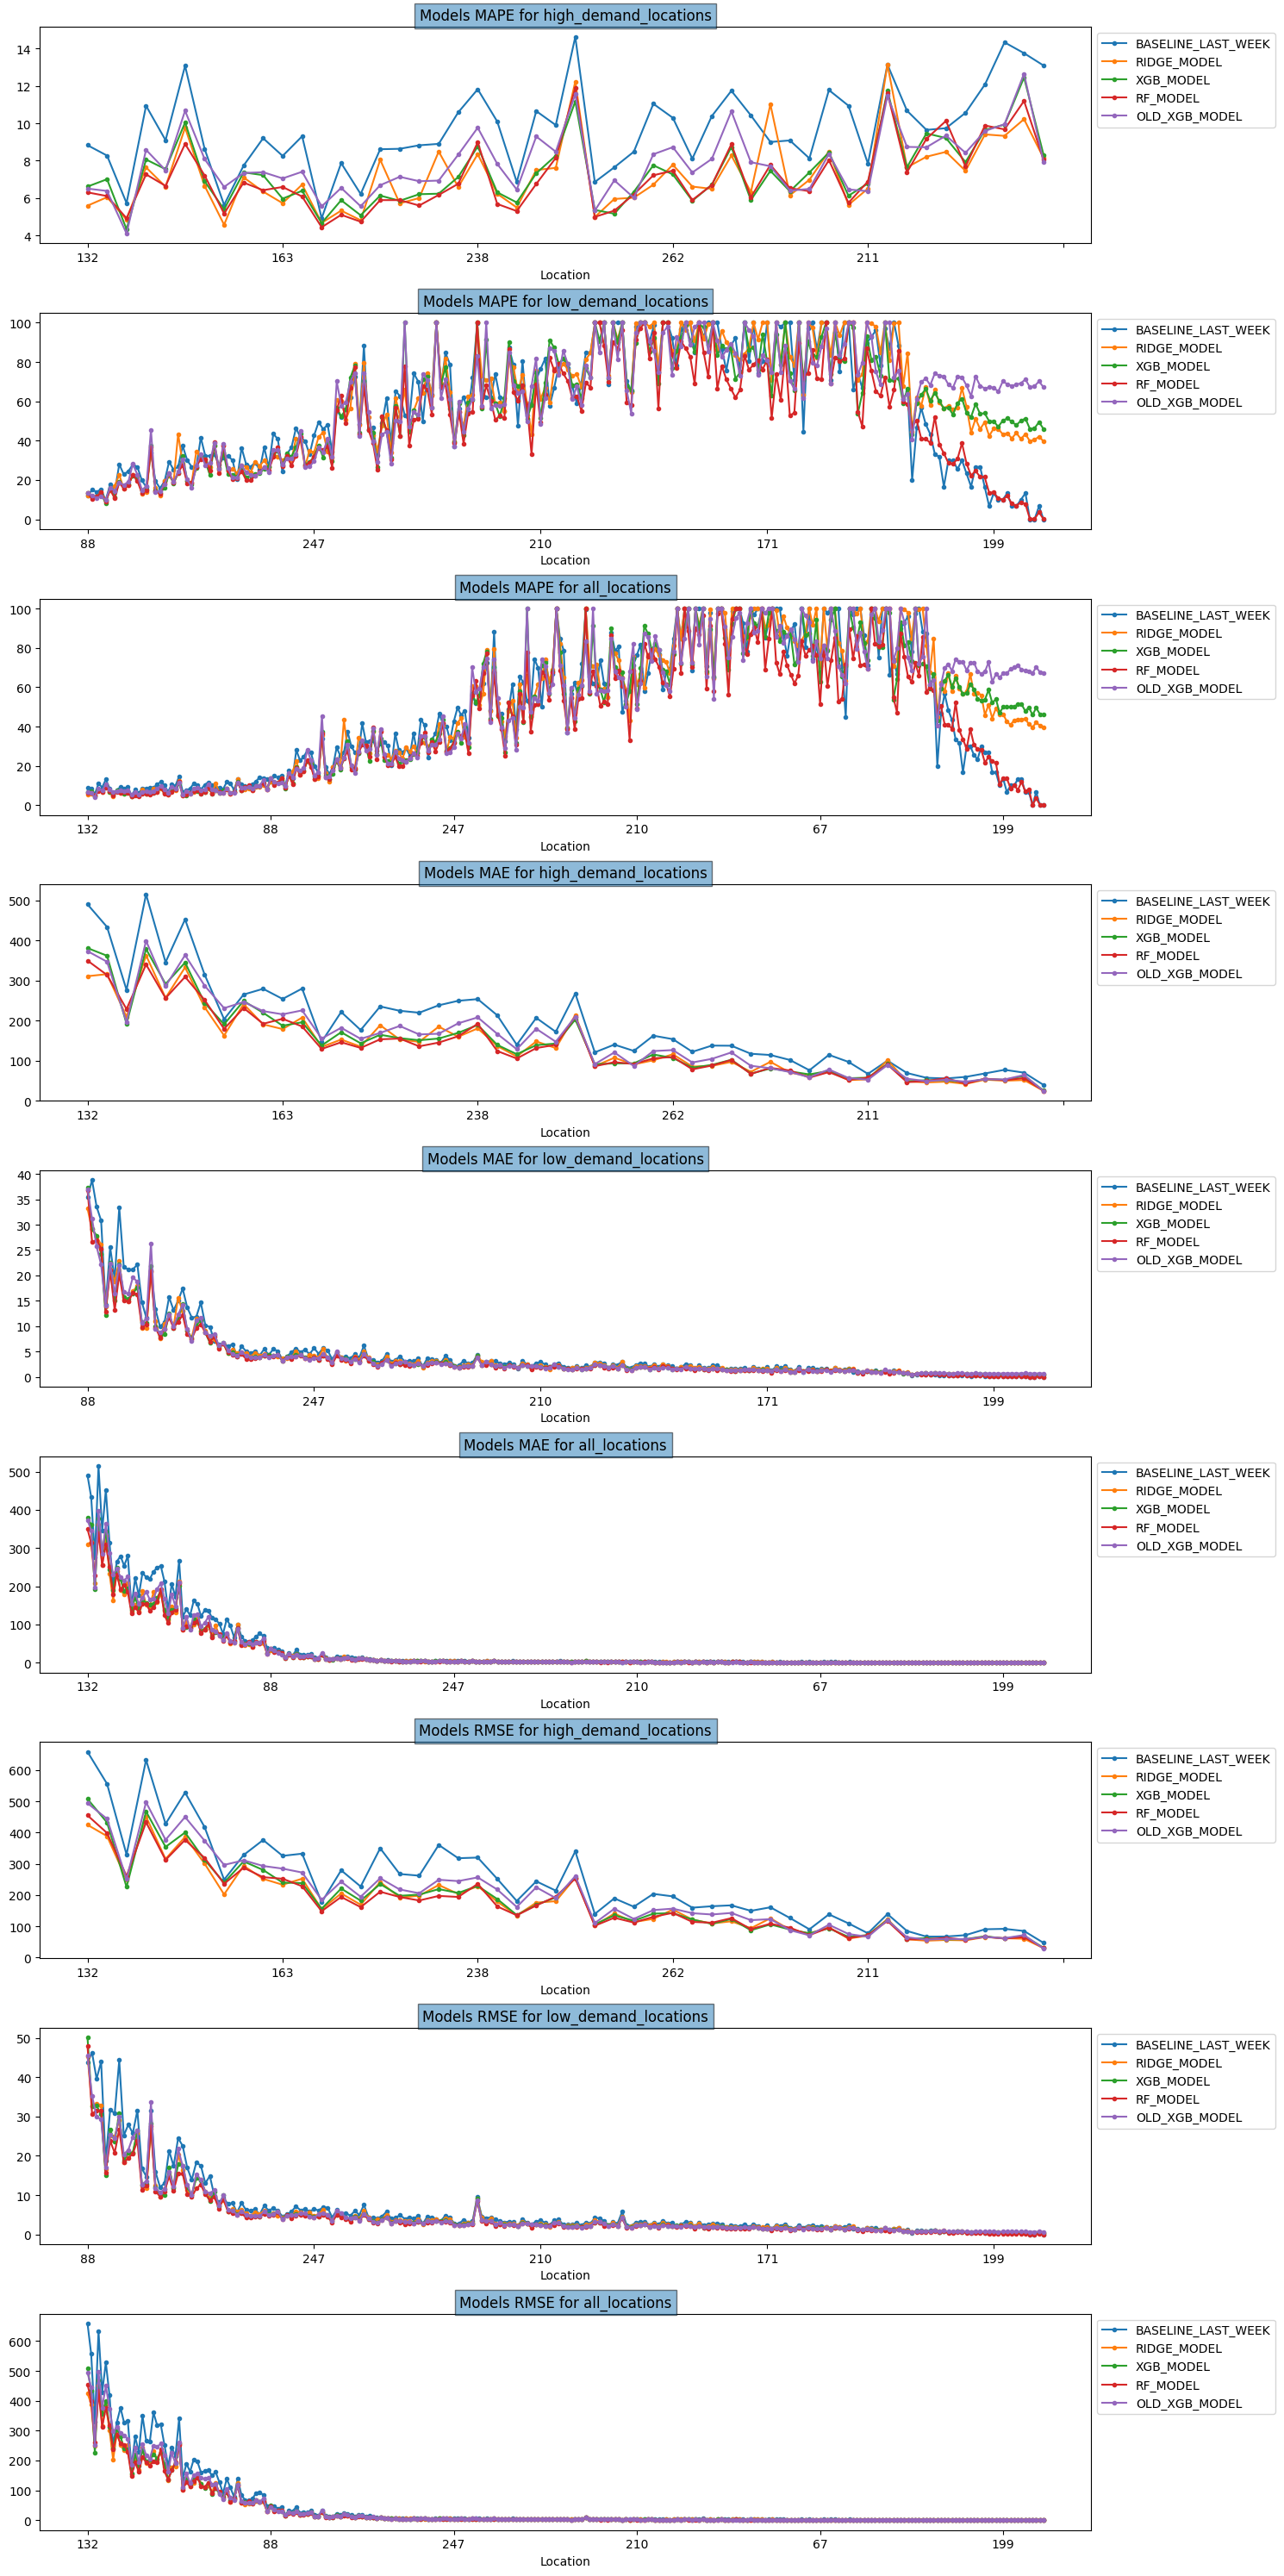

In [78]:
plot(predictions_mean_error_dict, 'Location')

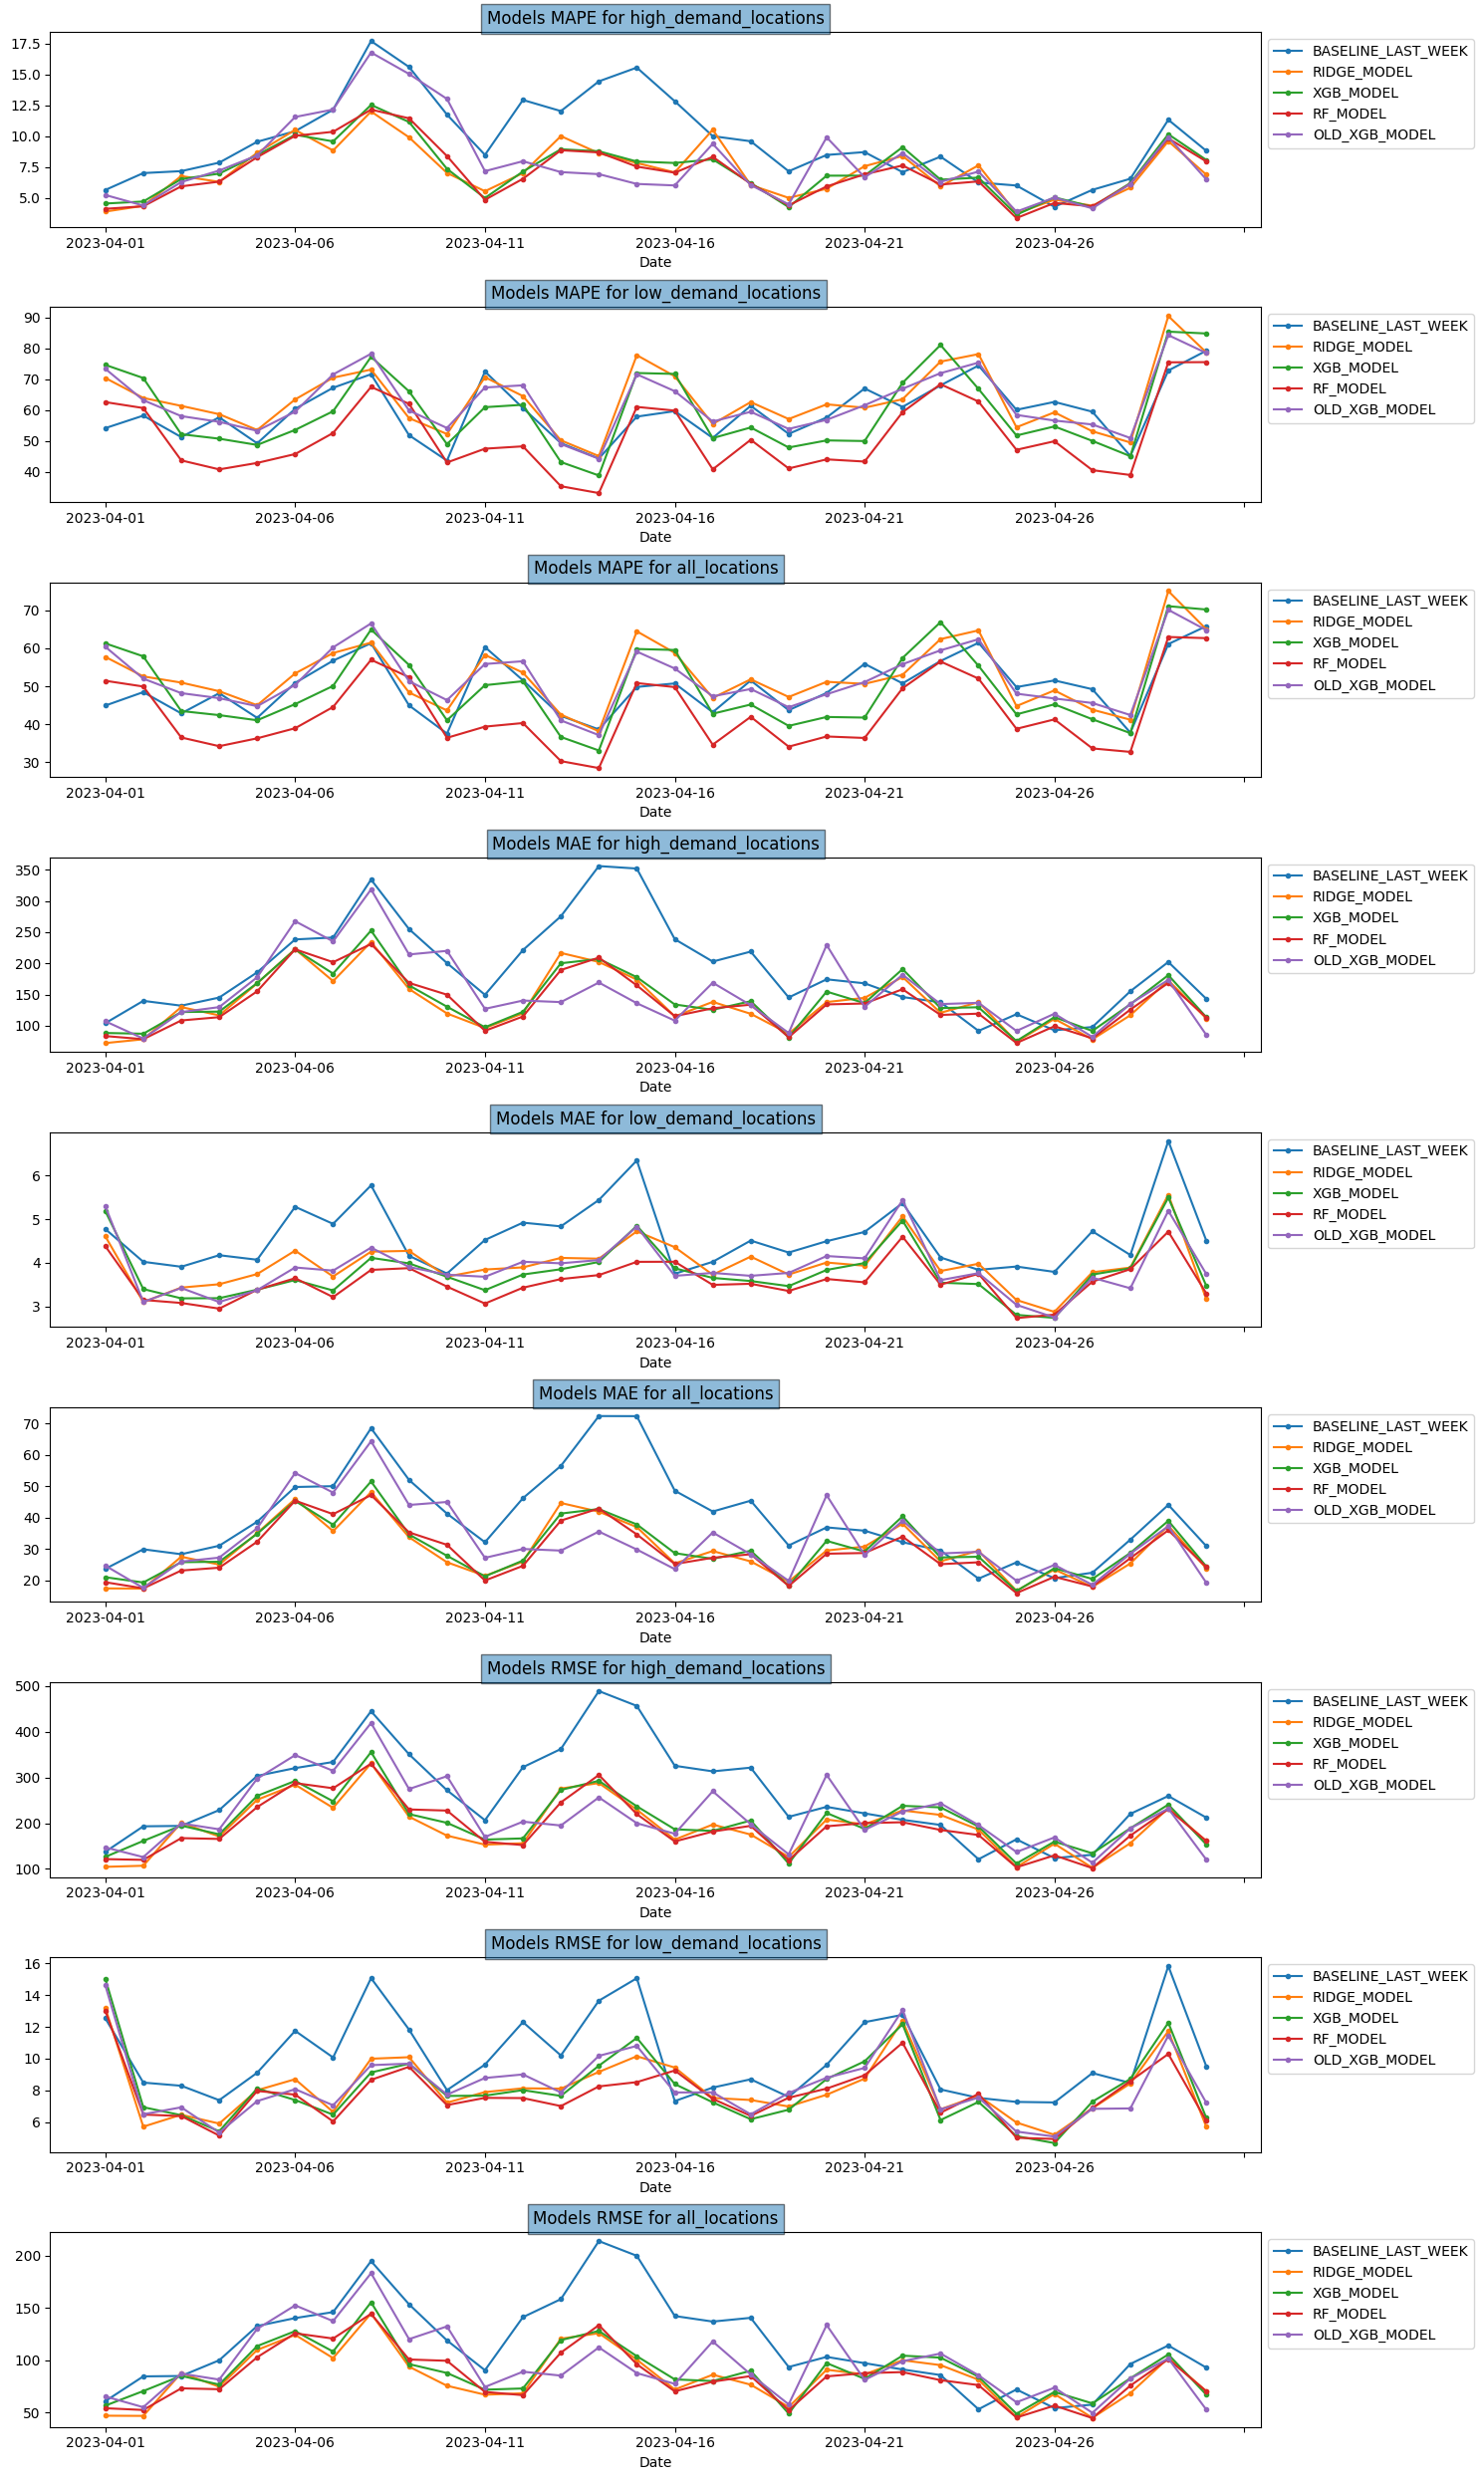

In [67]:
plot(predictions_mean_error_dict, 'Date')

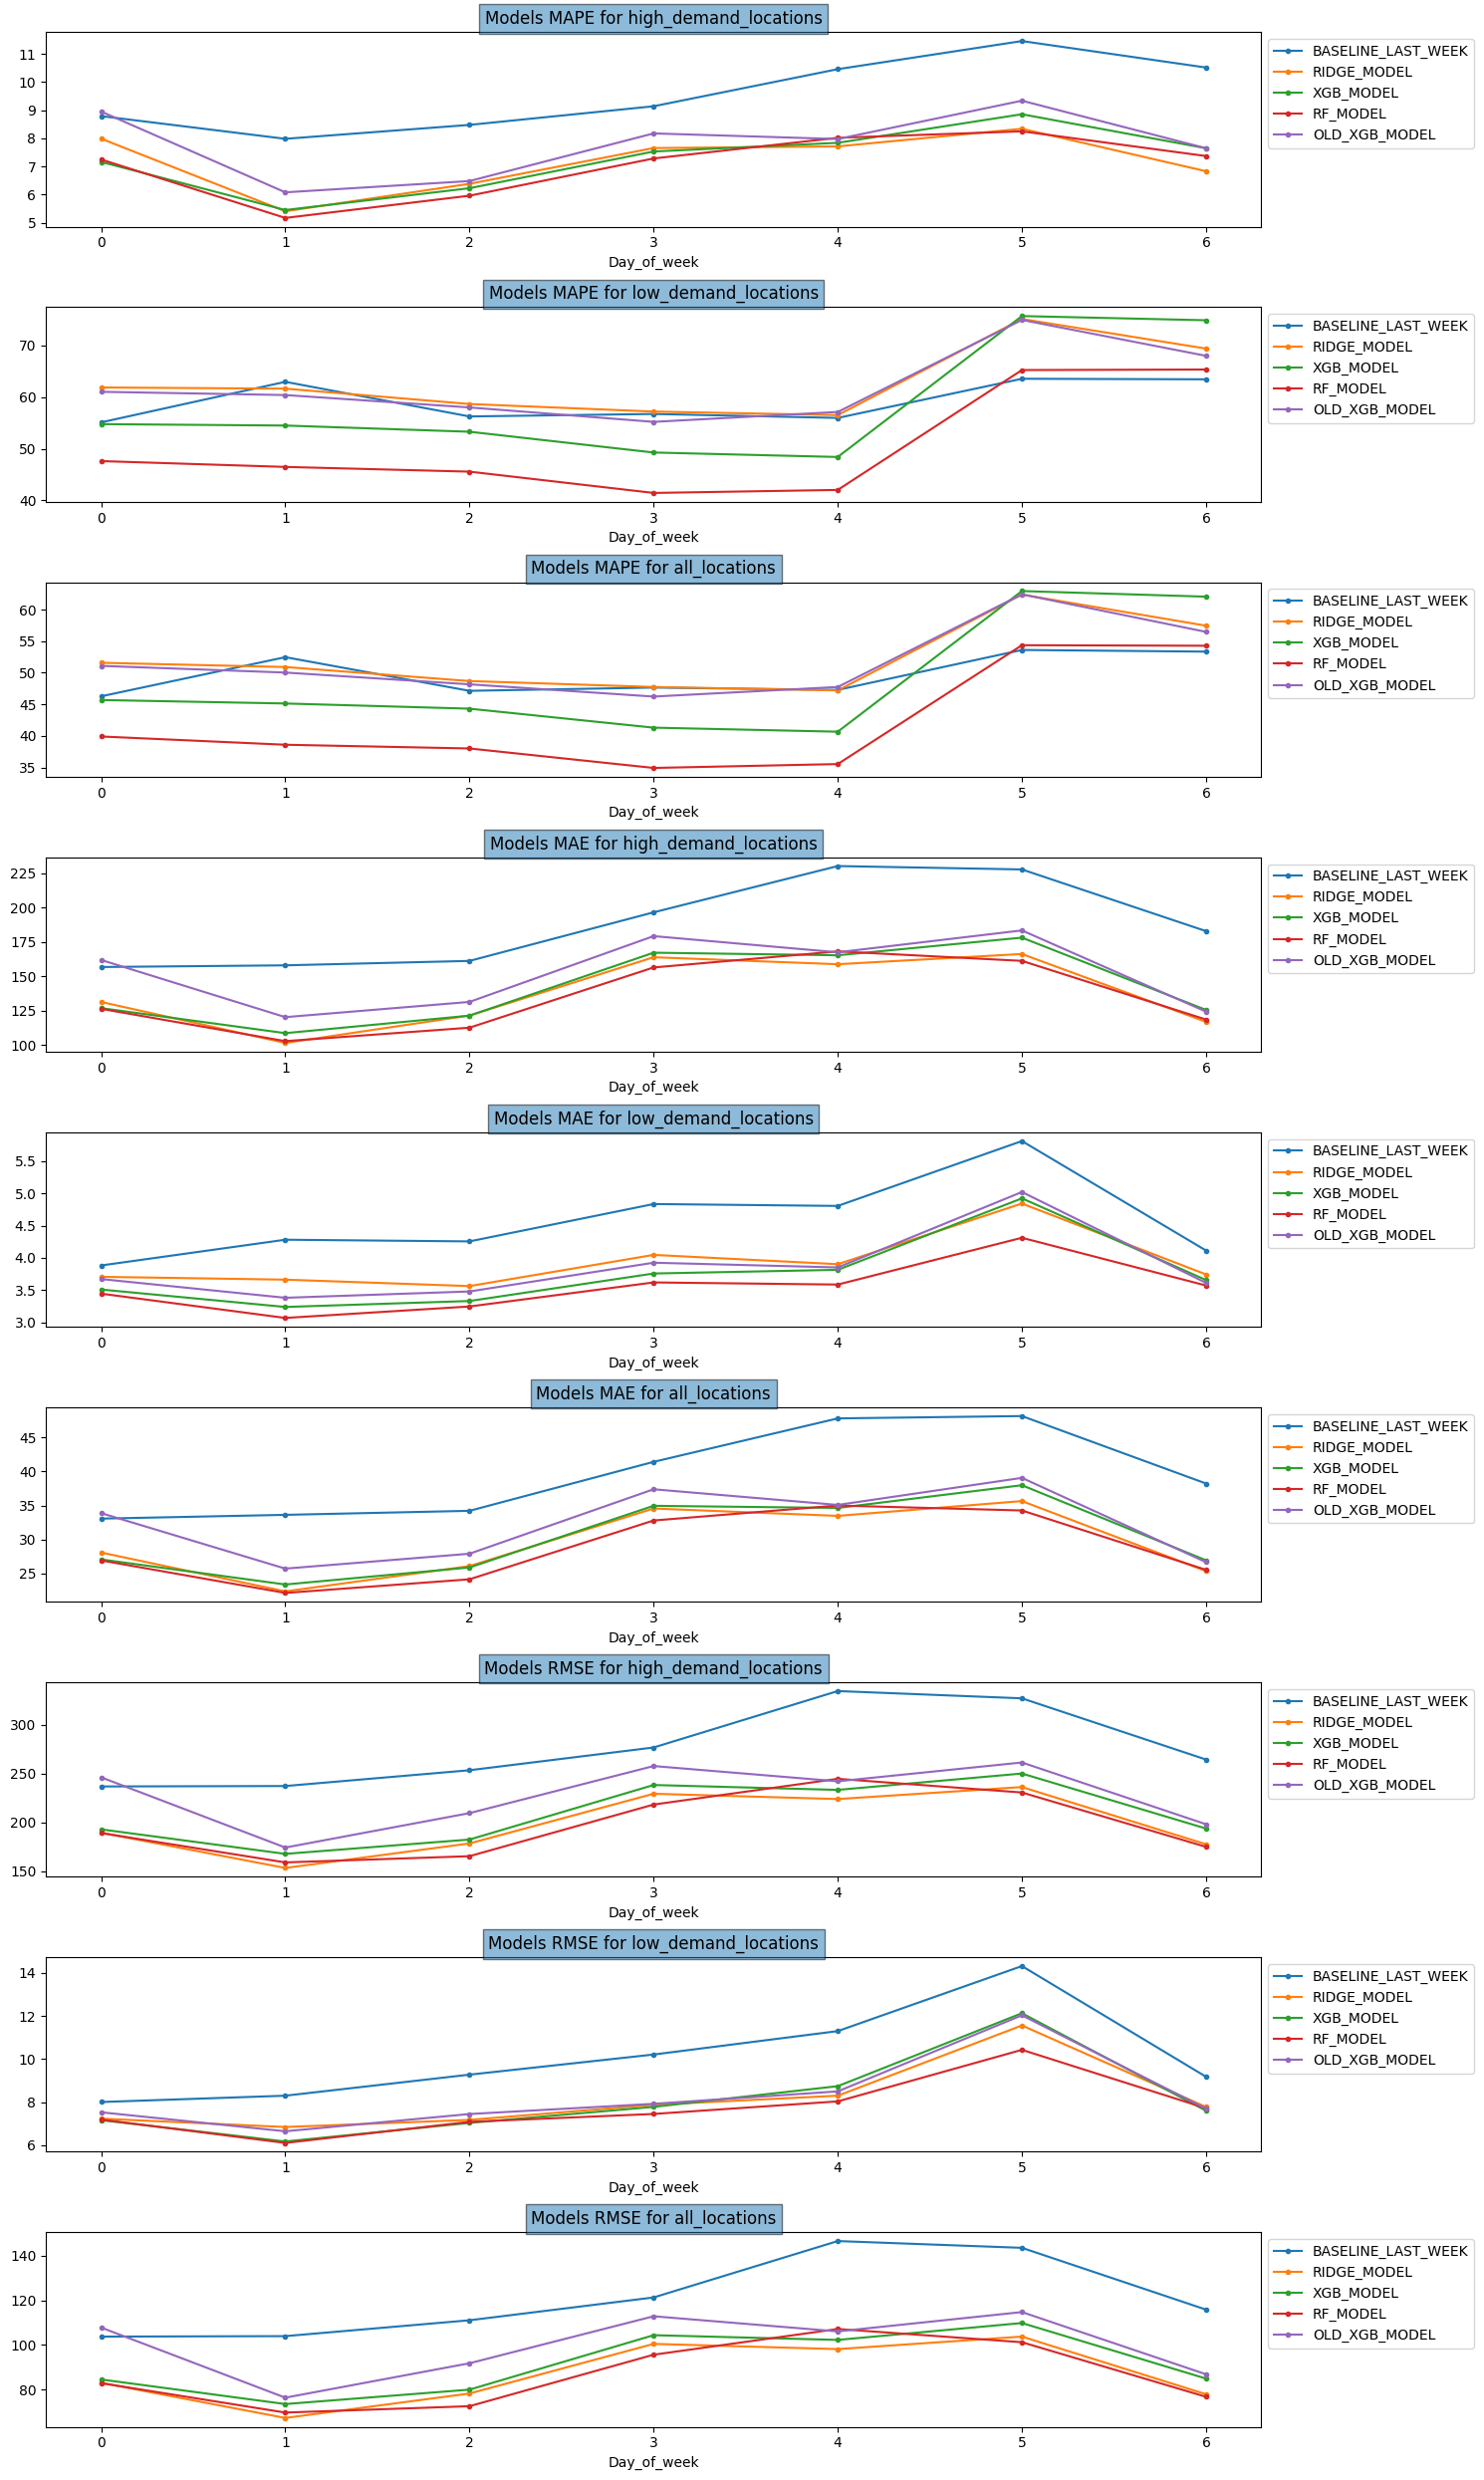

In [68]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [69]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['Location']]
                categorized_df = error_df.merge(sorted_index, on=['Location'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()
                report_dict[cat]['MEAN'][model] = categorized_df['Demand'].mean()

    return report_dict

In [70]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [71]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES,METRICS + ['MEAN']], 
                                                     names=['location CATEGORIES:', 'Error Metrics:']))


In [72]:
df.style.format('{:.2f}')